# 纯工程 - 多输入多输出

该例子只是纯工程例子，样本数据随机生成，仅仅是为了描述`可能`。

## 导入包

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

models = tf.keras.models
layers = tf.keras.layers
losses = tf.keras.losses
optimizers = tf.keras.optimizers
activations = tf.keras.activations
Input = tf.keras.Input
utils = tf.keras.utils
TensorBoard = tf.keras.callbacks.TensorBoard

# 文本片段词典大小
text_vocabulary_size = 1000
# 问题词典大小
question_vocabulary_size = 1000
# 输入文本长度
maxlen = 50
# 样本数量
num_samples = 1000
# 收入分类数
num_income_group = 10

## 3. 准备多输入层

In [2]:
# 处理文本输入
text_input = Input(shape=(None, ), dtype='int32', name='texts')
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input)
encoded_text = layers.LSTM(32)(embedded_text)

# 处理问题输入
question_input = Input(shape=(None, ), dtype='int32', name='questions')
embedded_question = layers.Embedding(question_vocabulary_size, 64)(question_input)
encoded_question = layers.LSTM(64)(embedded_question)

# 连接编码后的问题和文本
concatenated = layers.concatenate([encoded_text, encoded_question], axis=-1)

W0726 06:19:44.338697 139992302946112 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0726 06:19:44.351014 139992302946112 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 4. 准备多输出层

In [3]:
# 二分类问题
gender_prediction = layers.Dense(
    1,
    activation=activations.sigmoid,
    name='gender')(concatenated)


# 多分类问题
income_prediction = layers.Dense(
    num_income_group,
    activation=activations.softmax,
    name='income')(concatenated)

# 回归问题
age_prediction = layers.Dense(1, name='age')(concatenated)

## 5. 构建模型

In [4]:
model = models.Model(
    [text_input, question_input],
    [age_prediction, income_prediction, gender_prediction]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
texts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
questions (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     64000       texts[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     64000       questions[0][0]                  
______________________________________________________________________________________________

## 6. 编译模型

In [5]:
model.compile(
    optimizer=optimizers.Adam(),  # 这个注释只是为了自动格式化
    loss={
        'age': losses.mse,
        'income': losses.categorical_crossentropy,
        'gender': losses.binary_crossentropy
    },
    # 对总loss值贡献度，详情可参考：https://tensorflow.google.cn/api_docs/python/tf/keras/Model#compile
    loss_weights={
        'age': 0.25,
        'income': 1.,
        'gender': 10.
    },
    metrics = ['accuracy', 'mae', 'mse']
)

W0726 06:19:45.078963 139992302946112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 7. 准备模拟数据

In [6]:
# 准备模拟数据
# x_train(s)
texts = np.random.randint(1, text_vocabulary_size, size=(num_samples, maxlen))
questions = np.random.randint(1, question_vocabulary_size, size=(num_samples, maxlen))

# y_train(s)
# 1. 预测age是回归问题， lables.shape = (num_simples,)
age_targets = np.random.randint(16, 40, size=num_samples)

# 2. 预测income是多分类问题，有2种标签向量化方式，这边使用one-hot编码,lables.shape = (num_samples, num_income_group)
income_targets = np.random.randint(num_income_group, size=num_samples)
income_targets = utils.to_categorical(income_targets, num_income_group)

# 3. 预测gender是两分类问题, labels.shape = (num_samples, )
gender_targets = np.random.randint(2, size=num_samples)

## 8. 训练模型

In [7]:
history = model.fit(
    {
        'texts': texts,  # 这个注释只是为了自动格式化
        'questions': questions
    },
    {
        'age': age_targets,
        'income': income_targets,
        'gender': gender_targets
    },
    epochs=100,
    batch_size=64,
    validation_split=0.2,    
    callbacks = [TensorBoard(log_dir='../results/muti-input-and-output/logs')]    
)

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 2s 2ms/sample - loss: 209.6750 - age_loss: 800.6895 - income_loss: 2.3034 - gender_loss: 0.6935 - age_acc: 0.0000e+00 - age_mean_absolute_error: 27.4613 - age_mean_squared_error: 801.7559 - income_acc: 0.0925 - income_mean_absolute_error: 0.1800 - income_mean_squared_error: 0.0900 - gender_acc: 0.5050 - gender_mean_absolute_error: 0.5000 - gender_mean_squared_error: 0.2501 - val_loss: 207.4915 - val_age_loss: 779.6553 - val_income_loss: 2.3097 - val_gender_loss: 0.6889 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 27.3204 - val_age_mean_squared_error: 792.8373 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1801 - val_income_mean_squared_error: 0.0901 - val_gender_acc: 0.4550 - val_gender_mean_absolute_error: 0.5017 - val_gender_mean_squared_error: 0.2521
Epoch 2/100
800/800 [==============================] - 1s 1ms/sample - loss: 165.8818 - age_loss: 620.7752 - 

Epoch 11/100
800/800 [==============================] - 1s 1ms/sample - loss: 24.9675 - age_loss: 62.5161 - income_loss: 2.3035 - gender_loss: 0.6939 - age_acc: 0.0000e+00 - age_mean_absolute_error: 6.6590 - age_mean_squared_error: 62.8999 - income_acc: 0.1063 - income_mean_absolute_error: 0.1798 - income_mean_squared_error: 0.0900 - gender_acc: 0.4950 - gender_mean_absolute_error: 0.5003 - gender_mean_squared_error: 0.2504 - val_loss: 24.7357 - val_age_loss: 60.4994 - val_income_loss: 2.3137 - val_gender_loss: 0.6928 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 6.6113 - val_age_mean_squared_error: 61.9760 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1801 - val_income_mean_squared_error: 0.0902 - val_gender_acc: 0.5450 - val_gender_mean_absolute_error: 0.4999 - val_gender_mean_squared_error: 0.2499
Epoch 12/100
800/800 [==============================] - 1s 1ms/sample - loss: 23.8123 - age_loss: 57.9864 - income_loss: 2.3029 - gender_loss: 0.6941 - age_acc: 0

Epoch 21/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1905 - age_loss: 48.1943 - income_loss: 2.3020 - gender_loss: 0.6932 - age_acc: 0.0000e+00 - age_mean_absolute_error: 5.9593 - age_mean_squared_error: 47.8245 - income_acc: 0.1275 - income_mean_absolute_error: 0.1798 - income_mean_squared_error: 0.0900 - gender_acc: 0.5000 - gender_mean_absolute_error: 0.5000 - gender_mean_squared_error: 0.2500 - val_loss: 21.0100 - val_age_loss: 41.4119 - val_income_loss: 2.3038 - val_gender_loss: 0.6941 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 5.7413 - val_age_mean_squared_error: 47.1342 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1800 - val_income_mean_squared_error: 0.0902 - val_gender_acc: 0.5450 - val_gender_mean_absolute_error: 0.4991 - val_gender_mean_squared_error: 0.2492
Epoch 22/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1791 - age_loss: 47.1533 - income_loss: 2.3052 - gender_loss: 0.6937 - age_acc: 0

Epoch 31/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1480 - age_loss: 47.6576 - income_loss: 2.3054 - gender_loss: 0.6933 - age_acc: 0.0000e+00 - age_mean_absolute_error: 5.9583 - age_mean_squared_error: 47.6360 - income_acc: 0.1275 - income_mean_absolute_error: 0.1797 - income_mean_squared_error: 0.0900 - gender_acc: 0.5025 - gender_mean_absolute_error: 0.5000 - gender_mean_squared_error: 0.2501 - val_loss: 20.9233 - val_age_loss: 52.3676 - val_income_loss: 2.3161 - val_gender_loss: 0.6976 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 5.7171 - val_age_mean_squared_error: 46.6307 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1801 - val_income_mean_squared_error: 0.0902 - val_gender_acc: 0.4550 - val_gender_mean_absolute_error: 0.5010 - val_gender_mean_squared_error: 0.2512
Epoch 32/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1650 - age_loss: 47.5750 - income_loss: 2.3016 - gender_loss: 0.6954 - age_acc: 0

Epoch 41/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1534 - age_loss: 47.6133 - income_loss: 2.3073 - gender_loss: 0.6934 - age_acc: 0.0000e+00 - age_mean_absolute_error: 5.9583 - age_mean_squared_error: 47.6354 - income_acc: 0.1125 - income_mean_absolute_error: 0.1799 - income_mean_squared_error: 0.0901 - gender_acc: 0.5000 - gender_mean_absolute_error: 0.5001 - gender_mean_squared_error: 0.2503 - val_loss: 20.9294 - val_age_loss: 44.8800 - val_income_loss: 2.2993 - val_gender_loss: 0.6992 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 5.7164 - val_age_mean_squared_error: 46.6216 - val_income_acc: 0.1050 - val_income_mean_absolute_error: 0.1800 - val_income_mean_squared_error: 0.0902 - val_gender_acc: 0.4550 - val_gender_mean_absolute_error: 0.5014 - val_gender_mean_squared_error: 0.2516
Epoch 42/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1716 - age_loss: 47.4478 - income_loss: 2.3062 - gender_loss: 0.6957 - age_acc: 0

Epoch 51/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1557 - age_loss: 47.7263 - income_loss: 2.3015 - gender_loss: 0.6945 - age_acc: 0.0000e+00 - age_mean_absolute_error: 5.9582 - age_mean_squared_error: 47.6347 - income_acc: 0.1275 - income_mean_absolute_error: 0.1798 - income_mean_squared_error: 0.0900 - gender_acc: 0.5000 - gender_mean_absolute_error: 0.5005 - gender_mean_squared_error: 0.2507 - val_loss: 20.9168 - val_age_loss: 47.5706 - val_income_loss: 2.3191 - val_gender_loss: 0.6955 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 5.7163 - val_age_mean_squared_error: 46.6197 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1801 - val_income_mean_squared_error: 0.0902 - val_gender_acc: 0.4550 - val_gender_mean_absolute_error: 0.5008 - val_gender_mean_squared_error: 0.2509
Epoch 52/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1701 - age_loss: 47.6026 - income_loss: 2.2996 - gender_loss: 0.6960 - age_acc: 0

Epoch 61/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1628 - age_loss: 47.2761 - income_loss: 2.3061 - gender_loss: 0.6942 - age_acc: 0.0000e+00 - age_mean_absolute_error: 5.9588 - age_mean_squared_error: 47.6485 - income_acc: 0.1275 - income_mean_absolute_error: 0.1798 - income_mean_squared_error: 0.0901 - gender_acc: 0.5000 - gender_mean_absolute_error: 0.5003 - gender_mean_squared_error: 0.2506 - val_loss: 20.8942 - val_age_loss: 48.6437 - val_income_loss: 2.3225 - val_gender_loss: 0.6930 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 5.7156 - val_age_mean_squared_error: 46.6100 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1801 - val_income_mean_squared_error: 0.0904 - val_gender_acc: 0.5450 - val_gender_mean_absolute_error: 0.4995 - val_gender_mean_squared_error: 0.2495
Epoch 62/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1501 - age_loss: 47.4788 - income_loss: 2.3070 - gender_loss: 0.6935 - age_acc: 0

Epoch 71/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1533 - age_loss: 47.7225 - income_loss: 2.3032 - gender_loss: 0.6942 - age_acc: 0.0000e+00 - age_mean_absolute_error: 5.9578 - age_mean_squared_error: 47.6344 - income_acc: 0.1275 - income_mean_absolute_error: 0.1798 - income_mean_squared_error: 0.0900 - gender_acc: 0.5000 - gender_mean_absolute_error: 0.5004 - gender_mean_squared_error: 0.2505 - val_loss: 20.9006 - val_age_loss: 50.1865 - val_income_loss: 2.3251 - val_gender_loss: 0.6933 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 5.7140 - val_age_mean_squared_error: 46.5906 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1801 - val_income_mean_squared_error: 0.0902 - val_gender_acc: 0.4550 - val_gender_mean_absolute_error: 0.5004 - val_gender_mean_squared_error: 0.2504
Epoch 72/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1688 - age_loss: 47.5274 - income_loss: 2.3017 - gender_loss: 0.6958 - age_acc: 0

Epoch 81/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1519 - age_loss: 48.0428 - income_loss: 2.3002 - gender_loss: 0.6933 - age_acc: 0.0000e+00 - age_mean_absolute_error: 5.9609 - age_mean_squared_error: 47.6760 - income_acc: 0.1275 - income_mean_absolute_error: 0.1798 - income_mean_squared_error: 0.0900 - gender_acc: 0.5000 - gender_mean_absolute_error: 0.5000 - gender_mean_squared_error: 0.2500 - val_loss: 20.9231 - val_age_loss: 54.7537 - val_income_loss: 2.3027 - val_gender_loss: 0.6981 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 5.7154 - val_age_mean_squared_error: 46.6078 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1801 - val_income_mean_squared_error: 0.0902 - val_gender_acc: 0.4550 - val_gender_mean_absolute_error: 0.5012 - val_gender_mean_squared_error: 0.2513
Epoch 82/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1547 - age_loss: 47.7006 - income_loss: 2.3045 - gender_loss: 0.6941 - age_acc: 0

Epoch 91/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1538 - age_loss: 47.2116 - income_loss: 2.3031 - gender_loss: 0.6940 - age_acc: 0.0000e+00 - age_mean_absolute_error: 5.9587 - age_mean_squared_error: 47.6407 - income_acc: 0.1275 - income_mean_absolute_error: 0.1797 - income_mean_squared_error: 0.0900 - gender_acc: 0.4625 - gender_mean_absolute_error: 0.5004 - gender_mean_squared_error: 0.2504 - val_loss: 20.9185 - val_age_loss: 44.0630 - val_income_loss: 2.3173 - val_gender_loss: 0.6933 - val_age_acc: 0.0000e+00 - val_age_mean_absolute_error: 5.7196 - val_age_mean_squared_error: 46.6683 - val_income_acc: 0.0800 - val_income_mean_absolute_error: 0.1801 - val_income_mean_squared_error: 0.0903 - val_gender_acc: 0.4550 - val_gender_mean_absolute_error: 0.5001 - val_gender_mean_squared_error: 0.2501
Epoch 92/100
800/800 [==============================] - 1s 1ms/sample - loss: 21.1530 - age_loss: 47.8927 - income_loss: 2.3056 - gender_loss: 0.6935 - age_acc: 0

## 9. 使用matplotlib显示结果

### 9.1 整体损失

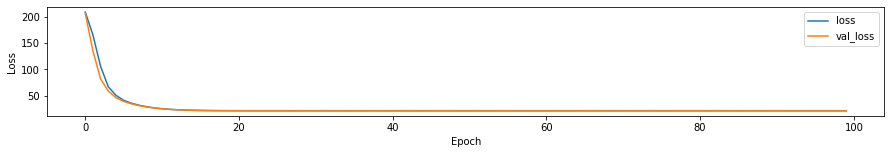

In [8]:
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'val_loss')
    plt.legend()
    plt.show()

### 9.2 年龄推测（回归问题）

回归问题不存在精度的概念，因此第一张图精度总是0，MAE或者MSE是回归问题主要参考指标

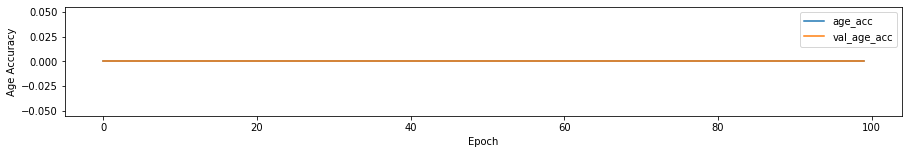

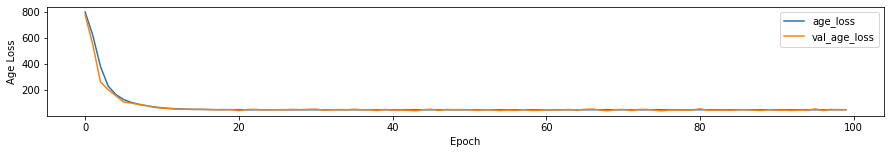

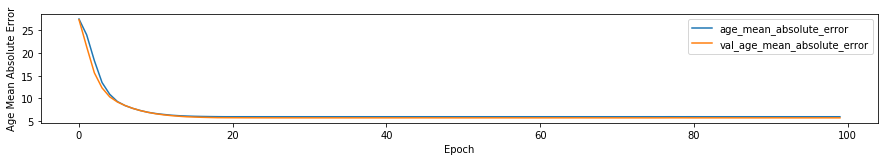

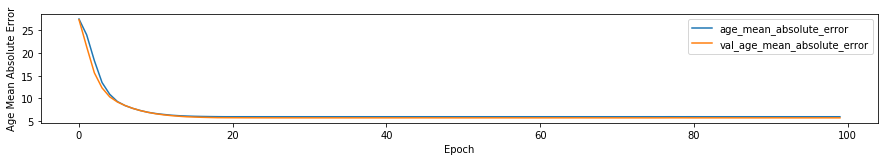

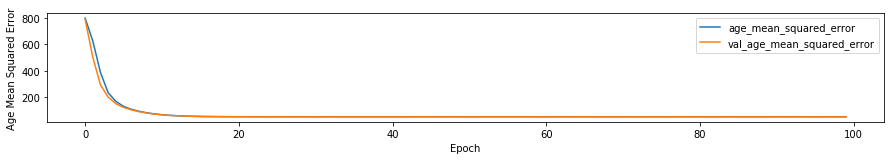

In [9]:
# ------------------------------------- Age ------------------------------------- 
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Age Accuracy')
    plt.plot(hist['epoch'], hist['age_acc'], label='age_acc')
    plt.plot(hist['epoch'], hist['val_age_acc'], label = 'val_age_acc')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Age Loss')
    plt.plot(hist['epoch'], hist['age_loss'], label='age_loss')
    plt.plot(hist['epoch'], hist['val_age_loss'], label = 'val_age_loss')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Age Mean Absolute Error')
    plt.plot(hist['epoch'], hist['age_mean_absolute_error'], label='age_mean_absolute_error')
    plt.plot(hist['epoch'], hist['val_age_mean_absolute_error'], label = 'val_age_mean_absolute_error')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Age Mean Absolute Error')
    plt.plot(hist['epoch'], hist['age_mean_absolute_error'], label='age_mean_absolute_error')
    plt.plot(hist['epoch'], hist['val_age_mean_absolute_error'], label = 'val_age_mean_absolute_error')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Age Mean Squared Error')
    plt.plot(hist['epoch'], hist['age_mean_squared_error'], label='age_mean_squared_error')
    plt.plot(hist['epoch'], hist['val_age_mean_squared_error'], label = 'val_age_mean_squared_error')
    plt.legend()
    
    plt.show()

### 9.3 收入区间推测（多分类问题）

因为是随机数，并且总类别为10，因此在这种情况下acc约等于10%， MAE和MSE不具有参考价值

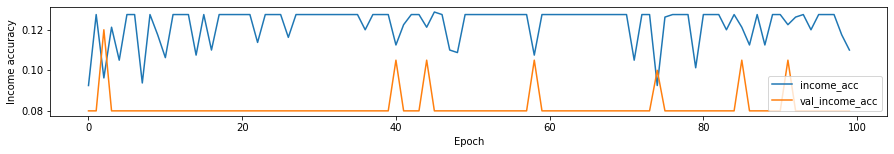

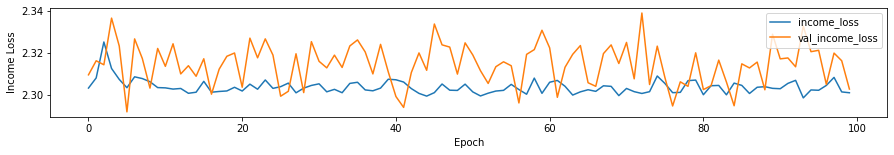

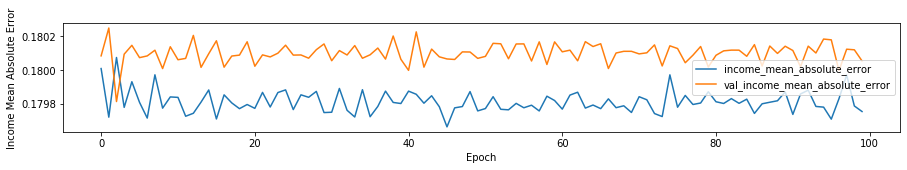

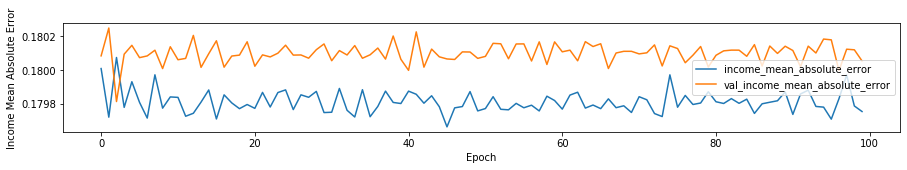

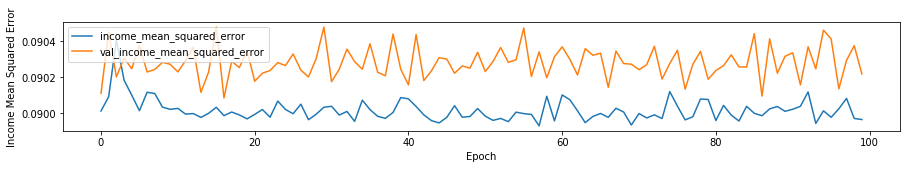

In [10]:
   
    # ------------------------------------- income ------------------------------------- 
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Income accuracy')
    plt.plot(hist['epoch'], hist['income_acc'], label='income_acc')
    plt.plot(hist['epoch'], hist['val_income_acc'], label = 'val_income_acc')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Income Loss')
    plt.plot(hist['epoch'], hist['income_loss'], label='income_loss')
    plt.plot(hist['epoch'], hist['val_income_loss'], label = 'val_income_loss')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Income Mean Absolute Error')
    plt.plot(hist['epoch'], hist['income_mean_absolute_error'], label='income_mean_absolute_error')
    plt.plot(hist['epoch'], hist['val_income_mean_absolute_error'], label = 'val_income_mean_absolute_error')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Income Mean Absolute Error')
    plt.plot(hist['epoch'], hist['income_mean_absolute_error'], label='income_mean_absolute_error')
    plt.plot(hist['epoch'], hist['val_income_mean_absolute_error'], label = 'val_income_mean_absolute_error')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Income Mean Squared Error')
    plt.plot(hist['epoch'], hist['income_mean_squared_error'], label='income_mean_squared_error')
    plt.plot(hist['epoch'], hist['val_income_mean_squared_error'], label = 'val_income_mean_squared_error')
    plt.legend()
    
    plt.show()

### 9.4 性别推测（二分类问题）

随机数下，二分类问题， acc约等于50%，MAE和MSE不具有参考价值

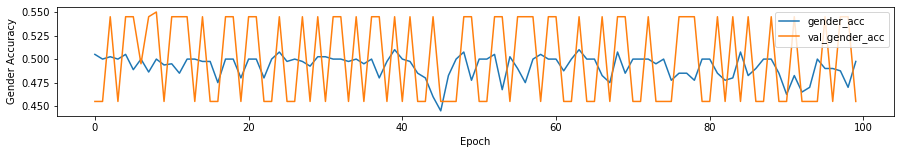

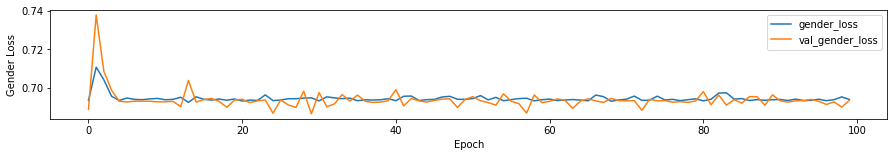

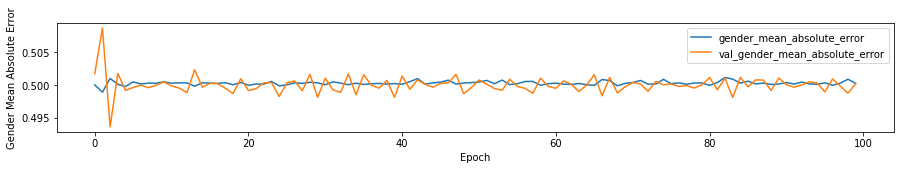

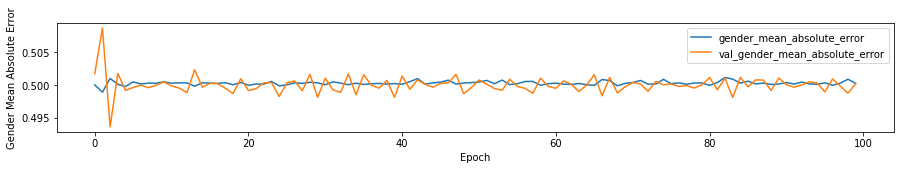

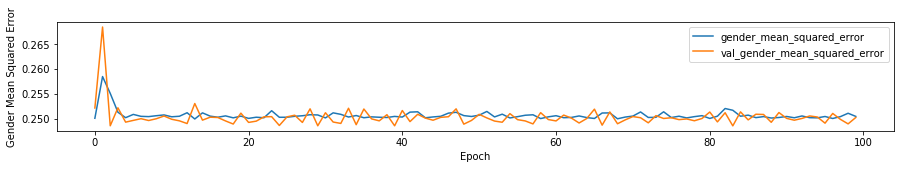

In [11]:
  # ------------------------------------- income ------------------------------------- 
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Gender Accuracy')
    plt.plot(hist['epoch'], hist['gender_acc'], label='gender_acc')
    plt.plot(hist['epoch'], hist['val_gender_acc'], label = 'val_gender_acc')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Gender Loss')
    plt.plot(hist['epoch'], hist['gender_loss'], label='gender_loss')
    plt.plot(hist['epoch'], hist['val_gender_loss'], label = 'val_gender_loss')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Gender Mean Absolute Error')
    plt.plot(hist['epoch'], hist['gender_mean_absolute_error'], label='gender_mean_absolute_error')
    plt.plot(hist['epoch'], hist['val_gender_mean_absolute_error'], label = 'val_gender_mean_absolute_error')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Gender Mean Absolute Error')
    plt.plot(hist['epoch'], hist['gender_mean_absolute_error'], label='gender_mean_absolute_error')
    plt.plot(hist['epoch'], hist['val_gender_mean_absolute_error'], label = 'val_gender_mean_absolute_error')
    plt.legend()
    
    plt.figure(figsize=(15, 2))
    plt.xlabel('Epoch')
    plt.ylabel('Gender Mean Squared Error')
    plt.plot(hist['epoch'], hist['gender_mean_squared_error'], label='gender_mean_squared_error')
    plt.plot(hist['epoch'], hist['val_gender_mean_squared_error'], label = 'val_gender_mean_squared_error')
    plt.legend()
    
    plt.show()